In [1]:
import pybamm as pb
import numpy as np
import matplotlib.pyplot as plt
from func_project import *

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Pre-simulation setups

In [ ]:
'''
    Pre-simulation settings
'''

# mesh settings
var_pts = {"x_n": 20, "x_s": 20, "x_p": 20, "r_n": 40, "r_p": 40}
submesh_types = pb.lithium_ion.DFN().default_submesh_types
submesh_types["negative particle"] = pb.MeshGenerator(
    pb.Exponential1DSubMesh, submesh_params={"side": "right"}
)
submesh_types["positive particle"] = pb.MeshGenerator(
    pb.Exponential1DSubMesh, submesh_params={"side": "right"}
)

# output variables that are of interest
output_variables = [
    "Throughput capacity [A.h]",
    "X-averaged negative total SEI thickness [m]",
    "Loss of capacity to negative SEI [A.h]",
    "Terminal voltage [V]",
    "Discharge capacity [A.h]",
    "Electrolyte potential [V]",
]

electron_limited_options = [
    "electron-migration limited",
    "interstitial-diffusion limited",
    "tunnelling limited",
    "VonKolzenberg2020",
]

solvent_limited_options = [
    "reaction limited",
    "solvent-diffusion limited",
    "ec reaction limited",
]

# writes output variables to a text file
f = open("output_vars.txt", "w",)
vars = sorted(pb.lithium_ion.DFN().variable_names())
for var in vars:
    f.write(f"{var}\n")
f.close()

### sweep through electron migration limited models

In [5]:
# fetch parameter values
parameters = update_parameter_set(pb.ParameterValues("Chen2020"))     # dataset on LGM50 cell
print(parameters)

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': <function electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019 at 0x000001AA48F76E80>,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019 at 0x000001AA4B9C94E0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019 at 0x000001AA4B9C93A0>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial SEI 

In [8]:
# define experimental details
cycles = 2
exp=pb.Experiment(
    [
        (
            "Charge at 1C until 4.2 V",
            "Rest for 1 hour",
            "Discharge at 1C until 2.5 V",
            "Rest for 1 hour",
        )
    ]* cycles
)

electron-migration limited
interstitial-diffusion limited
tunnelling limited
VonKolzenberg2020


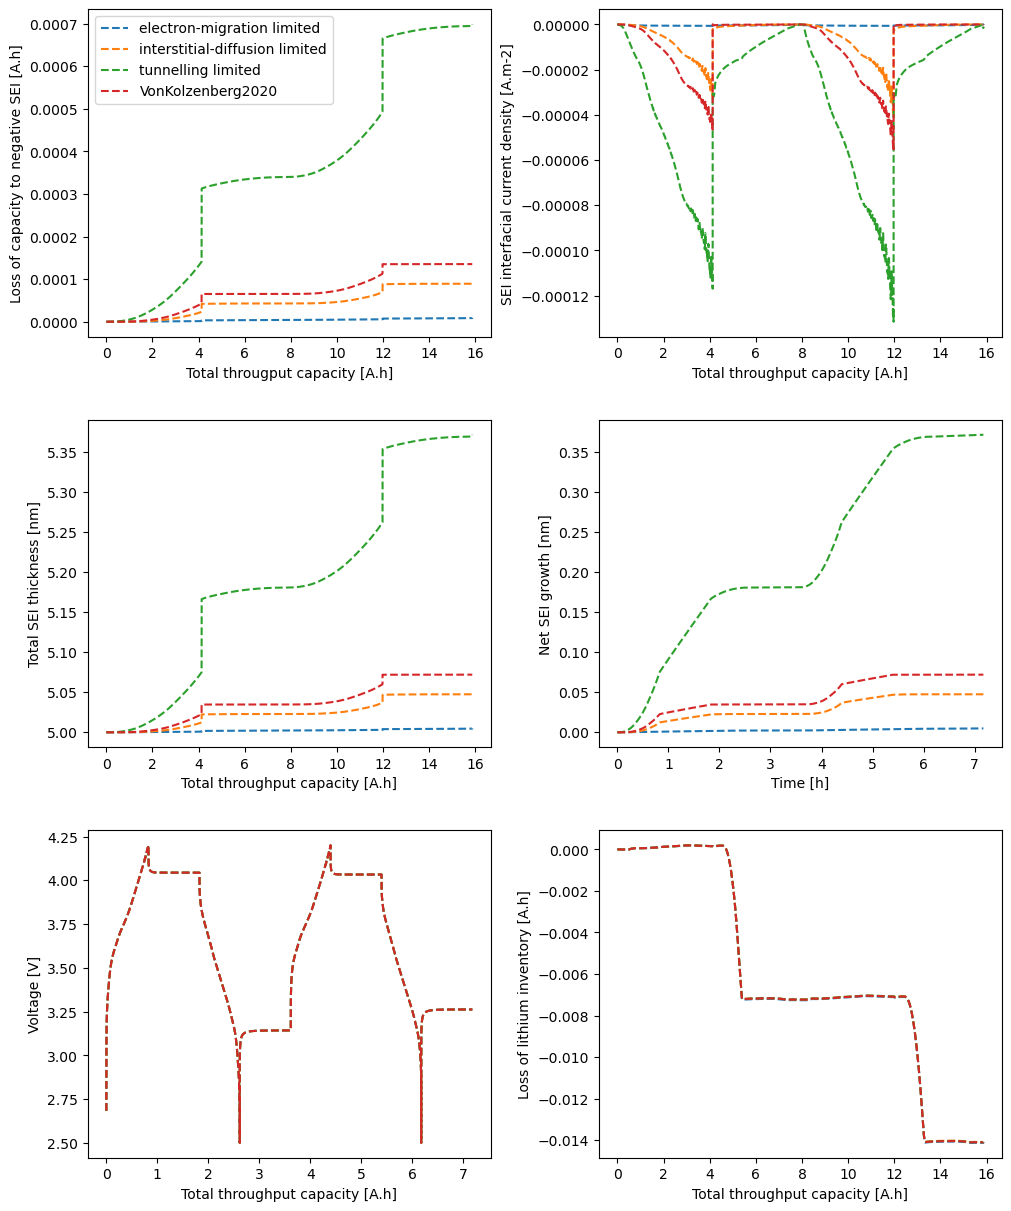

In [9]:
sols = []

electron_parameters = parameters.copy()
electron_parameters.update({    # parameter values used for Manmi2024 electron-limited models
    "Ambient temperature [K]": 298.15,
    "Initial temperature [K]": 298.15,

    'Initial SEI thickness [m]': 5e-9,
    'SEI kinetic rate constant [m.s-1]': 7.0e-13,
    'SEI solvent diffusivity [m2.s-1]': 1e-14,
    'Bulk solvent concentration [mol.m-3]': 4541.0,
    'SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    #'SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 7e-9,
    'Tunneling distance for electrons [m]': 1.4e-9,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    'SEI open-circuit potential [V]': 0.4,
}, check_already_exists=False)

for option in electron_limited_options:
    print(option)
    model = pb.lithium_ion.DFN(options={
        "SEI": option,
        "SEI porosity change": "true",
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
    })

    sim = pb.Simulation(
        model,
        parameter_values=electron_parameters,
        experiment=exp,
        var_pts=var_pts,
        submesh_types=submesh_types,
        solver=pb.IDAKLUSolver(),
    )

    sol = sim.solve(initial_soc=0)
    sol.save(f"{option}_5e-9_25C_{cycles}cycles.pkl")
    sols.append(sol)

plot_results(sols, electron_limited_options)

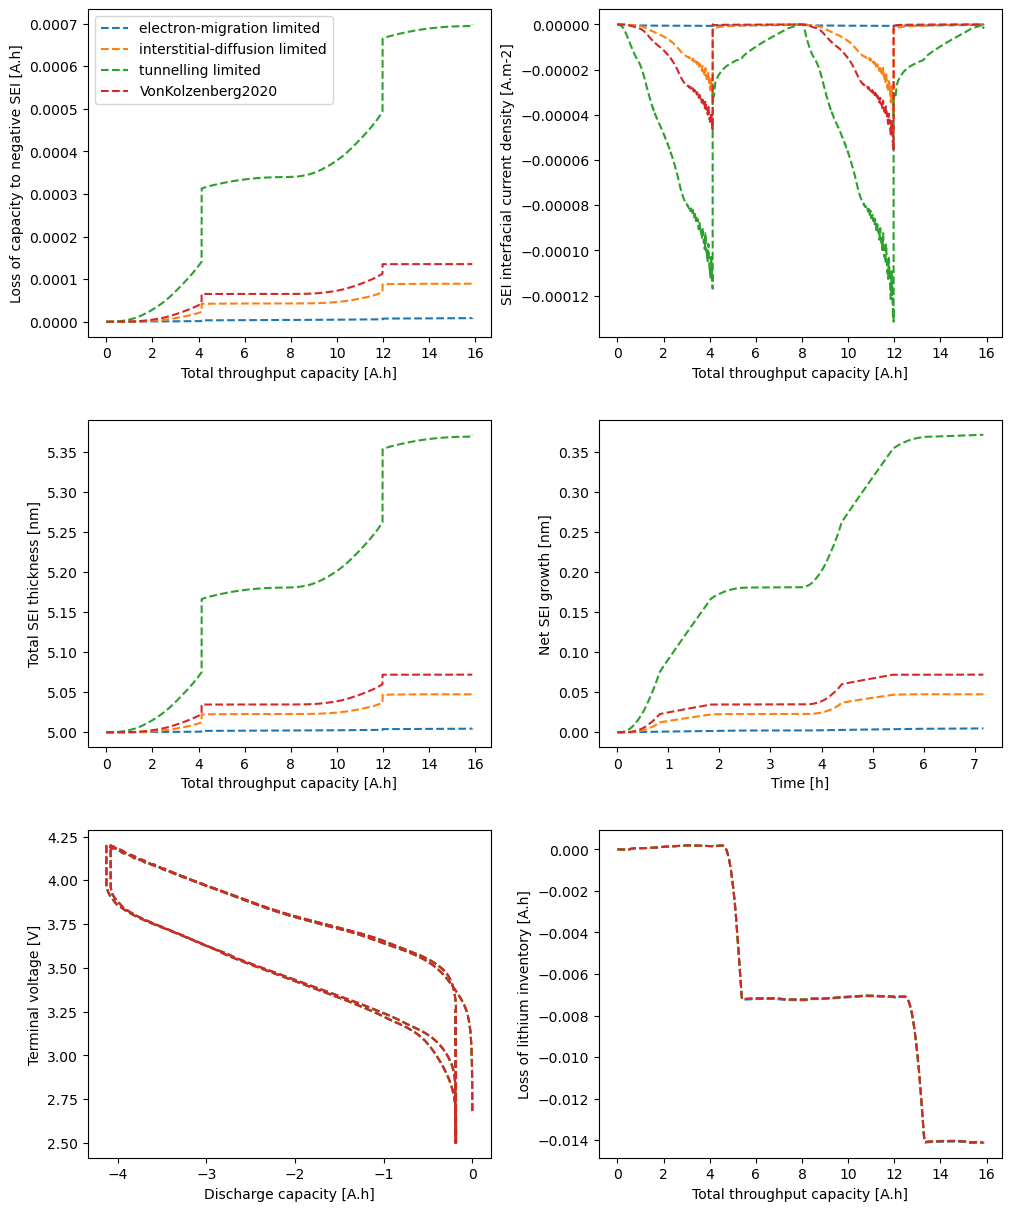

In [15]:
def result_plot(solution_set, variables):
    fig, axes = plt.subplots(3,2, layout="constrained", figsize=(10,12), gridspec_kw={"hspace": 0.1}, sharex=False)

    for index, sol in enumerate(solution_set):
        # independent variable
        Q_tot = sol["Throughput capacity [A.h]"].entries
        t = sol["Time [h]"].entries

        # various dependent variables
        Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
        J_SEI = sol["X-averaged negative electrode SEI interfacial current density [A.m-2]"].entries
        V_i = sol["Terminal voltage [V]"].entries
        # electrolyte_V = sol["Electrolyte potential [V]"].entries
        C_dis = sol["Discharge capacity [A.h]"].entries
        Q_LLI = sol["Total lithium lost [mol]"].entries #*96485.3 / 3600
        
        L_SEI = (sol["X-averaged negative total SEI thickness [m]"].entries) *1e9
        L_min = np.min(sol["X-averaged negative total SEI thickness [m]"].entries) *1e9
        delta_L = (L_SEI - L_min)

        # plot graph on the go

        axes[0][0].plot(Q_tot, Q_SEI, label=f"{variables[index]}", linestyle="--")
        axes[0][1].plot(Q_tot, J_SEI, label=f"{variables[index]}", linestyle="--")
        axes[1][0].plot(Q_tot, L_SEI, label=f"{variables[index]}", linestyle="--")
        axes[1][1].plot(t, delta_L, label=f"{variables[index]}", linestyle="--")
        axes[2][0].plot(C_dis, V_i, label=f"{variables[index]}", linestyle="--")
        axes[2][1].plot(Q_tot, Q_LLI, label=f"{variables[index]}", linestyle="--")
        
    # graph formatting
    axes[0][0].set_xlabel("Total throughput capacity [A.h]")
    axes[0][0].set_ylabel("Loss of capacity to negative SEI [A.h]") 
    axes[0][0].legend()
    
    axes[0][1].set_xlabel("Total throughput capacity [A.h]")
    axes[0][1].set_ylabel("SEI interfacial current density [A.m-2]")

    axes[1][0].set_xlabel("Total throughput capacity [A.h]")
    axes[1][0].set_ylabel("Total SEI thickness [nm]")


    axes[1][1].set_xlabel("Time [h]")
    axes[1][1].set_ylabel("Net SEI growth [nm]")

    axes[2][0].set_xlabel("Discharge capacity [A.h]")
    axes[2][0].set_ylabel("Terminal voltage [V]")

    axes[2][1].set_xlabel("Total throughput capacity [A.h]")
    axes[2][1].set_ylabel("Loss of lithium inventory [A.h]")

result_plot(sols, electron_limited_options)

### sweep through solvent limited models

In [ ]:
solvent_sols = []
solvent_parameters = parameters.copy()

for option in solvent_limited_options:
    model = pb.lithium_ion.DFN(options={
        "SEI": option,
        "SEI porosity change": "true",
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
    })

    sim = pb.Simulation(
        model,
        parameter_values=solvent_parameters,
        experiment=exp,
        var_pts=var_pts,
        submesh_types=submesh_types,
        solver=pb.IDAKLUSolver(),
    )

    sol = sim.solve(initial_soc=0)
    sol.save(f"{option}_5e-9_25C_{cycles}cycles.pkl")
    solvent_sols.append(sol)

plot_results(solvent_sols, solvent_limited_options)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1348, in structured_traceback
    return VerboseTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1195, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\

### plot against experimental data to compare

In [ ]:
'''
run a single discharge cycle of each SEI growth model at 1C and compare with experimental data
'''
sei_options = electron_limited_options + solvent_limited_options
print(sei_options)

solution = []

parameters = pb.ParameterValues("Chen2020")
electron_parameters = parameters.copy()
electron_parameters.update({    # parameter values used for Manmi2024 electron-limited models
    'Initial SEI thickness [m]': 5e-9,
    'SEI kinetic rate constant [m.s-1]': 7.0e-13,
    'SEI solvent diffusivity [m2.s-1]': 1e-14,
    'Bulk solvent concentration [mol.m-3]': 4541.0,
    'SEI electron conductivity [S.m-1]': 8.95e-15,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    #'SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
    'Lithium interstitial reference concentration [mol.m-3]': 1000,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
    'Tunneling distance for electrons [m]': 0,
    'SEI reaction exchange current density [A.m-2]': 0.0003,
    'SEI open-circuit potential [V]': 0.4,
}, check_already_exists=False)

experiment = pb.Experiment(
    [
        "Discharge at 1C until 2.5 V (5 seconds period)",
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

for option in sei_options:
    model = pb.lithium_ion.DFN(options={
        "SEI": option,
        "SEI porosity change": "true",
        #"thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
    })

    sim = pb.Simulation(
        model,
        parameter_values=electron_parameters,
        experiment=experiment,
        var_pts=var_pts,
        submesh_types=submesh_types,
        solver=pb.IDAKLUSolver(),
    )

    sol = sim.solve(initial_soc=1)
    #sol.save(f"{option}_5e-9_25C.pkl")
    solution.append(sol)

['electron-migration limited', 'interstitial-diffusion limited', 'tunnelling limited', 'VonKolzenberg2020', 'reaction limited', 'solvent-diffusion limited', 'ec reaction limited']


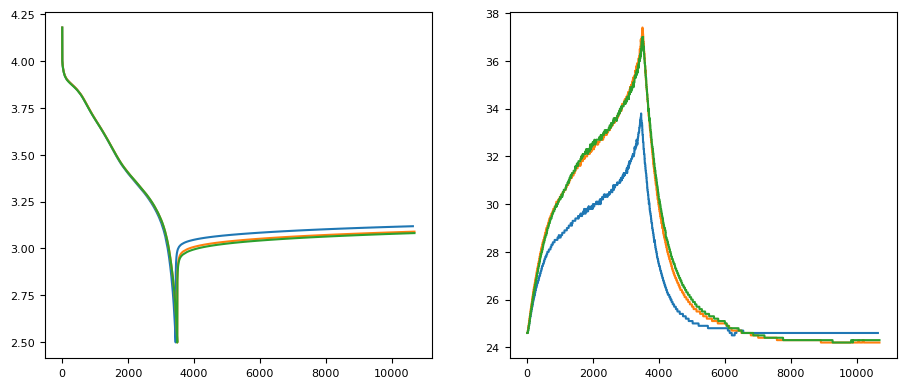

In [5]:
# plot the errors between SEI data and actual data?
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tec_reduced_model.set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
from tec_reduced_model.process_experimental_data import import_thermal_data, get_idxs

#plt.style.use(['science','vibrant'])

plt.rcParams.update({
    "font.family": "sans-serif",
    "text.usetex": False,
    "font.size": 8,
    "axes.labelsize": 10,
})


# Change simulation parameters here
temperature = 25  # in degC, valid values: 0, 10, 25
Crate = 1         # valid values: 0.5, 1, 2
cells_ignore = ["791"]    # cells to ignore, in this case we ignore cell 791 because the data for that cell is faulty

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
dataset = import_thermal_data(Crate, temperature)
data_conc = {"time": [], "voltage": [], "temperature": []}

for cell, data in dataset.items():
    if cell in cells_ignore:
        continue

    idx_start, idx_end = get_idxs(data, Crate * 5, 5 / 3)
    if len(idx_end) == 1:
        idx_end = np.append(idx_end, len(data["Time [s]"]))

    axes[0].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Voltage [V]"][idx_start[0] : idx_end[1]],
        label=cell,
    )
    axes[1].plot(
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        label=cell,
    )

    data_conc["time"] = np.append(
        data_conc["time"],
        data["Time [s]"][idx_start[0] : idx_end[1]]
        - data["Time [s]"][idx_start[0]],
    )
    data_conc["voltage"] = np.append(
        data_conc["voltage"], data["Voltage [V]"][idx_start[0] : idx_end[1]]
    )
    data_conc["temperature"] = np.append(
        data_conc["temperature"],
        data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
    )


for index, solution in enumerate(solution):
    axes[0].plot(
        solution["Time [s]"].entries,
        solution["Terminal voltage [V]"].entries,
        color="black",
        label=f"{sei_options[index]}",
    )

    axes[0].scatter(
        0,
        solution["Battery open-circuit voltage [V]"].entries[0],
        marker="x",
        color="black",
    )

    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Voltage (V)")

    axes[1].plot(
        solution["Time [s]"].entries,
        solution["X-averaged cell temperature [K]"].entries - 273.15,
        color="black",
        label=f"{sei_options[index]}",
    )

    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Cell temperature (°C)")
    axes[1].legend()
        
    fig.suptitle("Ambient temperature: {} °C, C-rate: {}C".format(temperature, Crate))    

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)


In [10]:
def rmse(solution, x_data, y_data):
    error = solution(x_data) - y_data
    error = error[~np.isnan(error)]  # remove NaNs due to extrapolation
    return np.sqrt(np.mean(error ** 2))


def R_squared(solution, x_data, y_data):
    y_bar = np.mean(y_data)
    SS_tot = np.sum((y_data - y_bar) ** 2)
    res = y_data - solution(x_data)
    res = res[~np.isnan(res)]  # remove NaNs due to extrapolation
    SS_res = np.sum(res ** 2)

    return 1 - SS_res / SS_tot

error = {}
error["RMSE_V"] = rmse(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["Rsq_V"] = R_squared(
    solution["Terminal voltage [V]"], data_conc["time"], data_conc["voltage"]
)
error["RMSE_T"] = rmse(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)
error["Rsq_T"] = R_squared(
    solution["X-averaged cell temperature [K]"],
    data_conc["time"],
    data_conc["temperature"] + 273.15,
)

print("Voltage RMSE: {:.2f} mV".format(error["RMSE_V"] * 1000))
print("Voltage R^2: {:.4f}".format(error["Rsq_V"]))
print("Temperature RMSE: {:.2f} °C".format(error["RMSE_T"]))
print("Temperature R^2: {:.4f}".format(error["Rsq_T"]))

Voltage RMSE: 631.36 mV
Voltage R^2: -4.7046
Temperature RMSE: 6.35 °C
Temperature R^2: -2.2656
